# Azure AI Agent service - Code interpreter

<img src="https://learn.microsoft.com/en-us/azure/ai-services/agents/media/agent-service-the-glue.png" width=800>

> https://learn.microsoft.com/en-us/azure/ai-services/agents/

In [1]:
#%pip install ipyplot
#%pip install matplotlib

## Load all dependencies

In [1]:
import glob
import json
import ipyplot
import matplotlib.pyplot as plt
import os
import sys
import time

from azure.ai.agents import AgentsClient 
from azure.identity import DefaultAzureCredential
from azure.ai.agents.models import CodeInterpreterTool, FilePurpose, ListSortOrder
from dotenv import load_dotenv
from openai import AzureOpenAI
from PIL import Image
from pathlib import Path

In [3]:
load_dotenv()

True

## Connect to AI Foundry Project 

In [4]:
endpoint = os.getenv("PROJECT_ENDPOINT")
print(f"Using endpoint: {endpoint}")
credential = DefaultAzureCredential()

project_client = AgentsClient(endpoint=endpoint, credential=credential)

Using endpoint: https://aq-ai-foundry-sweden-central.services.ai.azure.com/api/projects/firstProject


## Get example file

In [9]:
DATA_DIR = "data"

os.makedirs(DATA_DIR, exist_ok=True)

output_file = os.path.join(DATA_DIR, "titanic.csv")

In [10]:
!wget https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv -O $output_file

--2025-06-18 11:08:30--  https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘data/titanic.csv’

data/titanic.csv    100%[===================>]  58.89K  --.-KB/s    in 0.01s   

2025-06-18 11:08:30 (3.94 MB/s) - ‘data/titanic.csv’ saved [60302/60302]



In [11]:
model = "gpt-4o-mini"

## Upload file to agent

In [12]:
file = project_client.files.upload_and_poll(file_path=output_file,
                                                  purpose=FilePurpose.AGENTS)

print(f"Uploaded file, file ID: {file.id}")

Uploaded file, file ID: assistant-R4HjfQMTnq37TXiXeQ8oo1


## Create and agent with code interpreter tool

In [13]:
code_interpreter = CodeInterpreterTool(file_ids=[file.id])

# Create agent with code interpreter tool and tools_resources
agent = project_client.create_agent(
    model=os.environ["MODEL_DEPLOYMENT_NAME"],
    name="my-agent",
    instructions="You are helpful agent",
    tools=code_interpreter.definitions,
    tool_resources=code_interpreter.resources,
)
print(f"Created agent, agent ID: {agent.id} File ID: {file.id}")

Created agent, agent ID: asst_wnGhr0UcM9MG6b5hYxJnybtG File ID: assistant-R4HjfQMTnq37TXiXeQ8oo1


## Create a thread for the agent to run

In [14]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Plot a correlation matrix using the blues theme"

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

Created thread, thread ID: thread_TwnNG5enqbc0uvmq88YpXXN6
Created message, message ID: msg_gFCLXFWU2iEJ6LjGo6IZsmeN
Messages: <iterator object azure.core.paging.ItemPaged at 0x127c49be0>


## Run the code interpreter agent

In [15]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

Created run, run ID: run_a9zKffnVJ71nyopriy9IjL9v


## Get the messages generated by the run

In [16]:
messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

# Fetch and log all messages
messages = project_client.messages.list(thread_id=thread.id, order=ListSortOrder.ASCENDING)

# Print last messages from the thread
for msg in messages:
    if msg.text_messages:
        last_text = msg.text_messages[-1]
        print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x127bc5e50>
MessageRole.USER: Plot a correlation matrix using the blues theme
MessageRole.AGENT: Let's first examine the content of your uploaded file to determine its format and contents, then I'll plot the correlation matrix using a blue color theme.
MessageRole.AGENT: Your file is the Titanic dataset. I will plot the correlation matrix for the numerical columns using a blue color theme. Let's proceed!
MessageRole.AGENT: Here's the correlation matrix for the numerical columns in your Titanic dataset, visualized using a blue-themed heatmap. If you want to include more columns or adjust the display, let me know!


## Save image(s) generated by the run

In [17]:
IMAGES_DIR = "images"

images_list = []

# [START get_messages_and_save_files]
messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"./images/{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")


Messages: <iterator object azure.core.paging.ItemPaged at 0x127c45810>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/1_Azure Agent Service/NOTEBOOKS/images/assistant-Hqd7z4xcoHK4wFNi5MJeUG_image_file.png
MessageRole.AGENT: Your file is the Titanic dataset. I will plot the correlation matrix for the numerical columns using a blue color theme. Let's proceed!
MessageRole.AGENT: Let's first examine the content of your uploaded file to determine its format and contents, then I'll plot the correlation matrix using a blue color theme.
MessageRole.USER: Plot a correlation matrix using the blues theme


## Display image

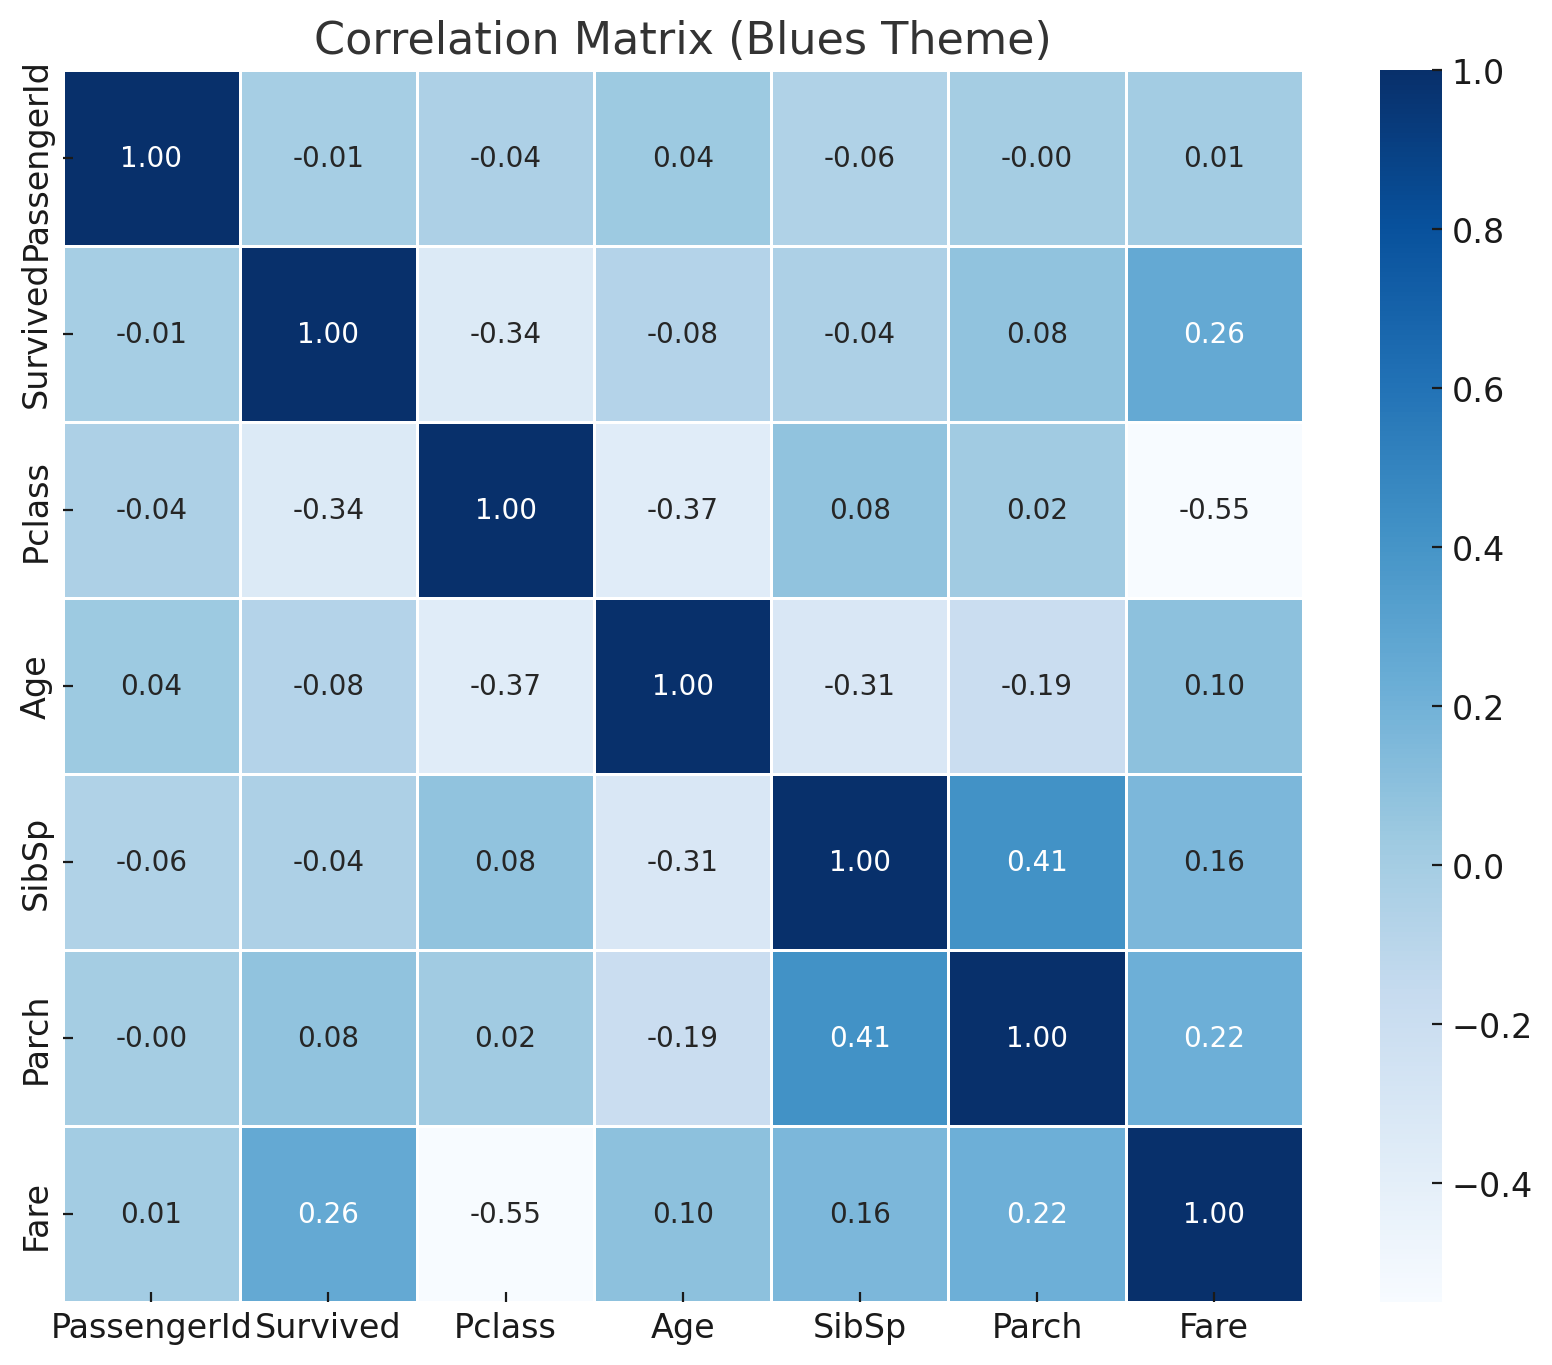

In [18]:
from IPython.display import Image, display
from pathlib import Path

file_id = img.image_file.file_id
file_name = f"./{file_id}_image_file.png"
file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))


## Example

In [19]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate a bivariate analysis of survival and pclass. Use some greens colors."

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_76VKefgyc5IIwqPJwZWYJv1K
Created message, message ID: msg_gC0I2cI5vbyUQu3fCgRn06hX


In [20]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

Created run, run ID: run_HrIUm5Q7d4ev2mrH3vCVmXFZ


In [21]:
run.usage

{'prompt_tokens': 3014, 'completion_tokens': 371, 'total_tokens': 3385, 'prompt_token_details': {'cached_tokens': 0}}

In [22]:
    IMAGES_DIR = "images"

    images_list = []

    # [START get_messages_and_save_files]
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x127c44c30>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/1_Azure Agent Service/NOTEBOOKS/assistant-XTVopAwsSFHYUYqeHrvci1_image_file.png
MessageRole.AGENT: The dataset contains the columns `Survived` for survival status and `Pclass` for passenger class.

Now, let's generate a green-themed countplot to visualize the relationship between survival and passenger class.
MessageRole.AGENT: Great! I will perform a bivariate analysis of `Survived` (survival) and `Pclass` (passenger class) from your dataset. The process will include:

1. Loading the data.
2. Creating a count plot with green hues to visualize the relationship.

Let's first inspect the file to ensure we use the correct column names and understand the data format.
MessageRole.USER: Generate a bivariate analysis of survival and pclass. Use some greens colors.


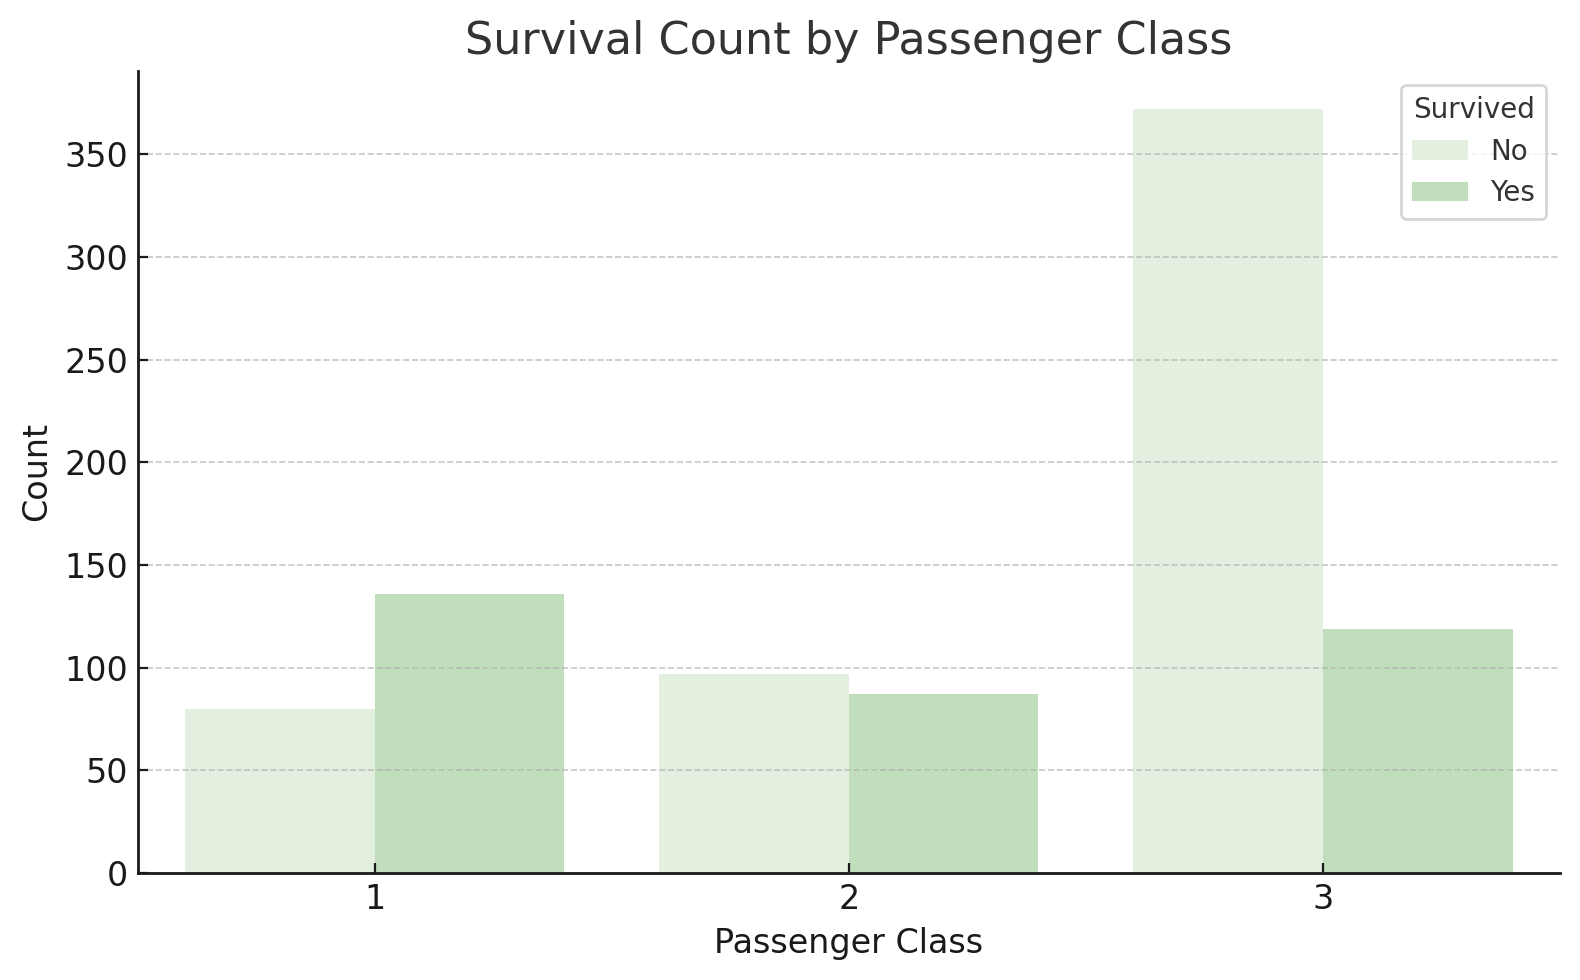

In [23]:
from IPython.display import Image, display
from pathlib import Path

file_id = img.image_file.file_id
file_name = f"./{file_id}_image_file.png"
file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))

## Example

In [24]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate a violin plot of Pclass by Age and Gender. Use lime and cyan colors."

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_Lr0QFeSWkmDwHAFc9bqt76tK
Created message, message ID: msg_ZfxKAZZhKB5nMho1reARRLk1


In [25]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

run.usage

Created run, run ID: run_3bBPO2974MsuJh3ppsexPkAM


{'prompt_tokens': 3012, 'completion_tokens': 395, 'total_tokens': 3407, 'prompt_token_details': {'cached_tokens': 0}}

In [26]:
    IMAGES_DIR = "images"

    images_list = []

    # [START get_messages_and_save_files]
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x127b95a30>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/1_Azure Agent Service/NOTEBOOKS/assistant-WemLYeeTu3PWrQLccknWGf_image_file.png
MessageRole.AGENT: The relevant columns for your plot are:

- `Pclass`: Passenger class.
- `Age`: Age of the passenger.
- `Sex`: Gender (values are `male` and `female`).

Now I'll generate a violin plot of Age by Pclass and hue by Sex, using lime and cyan colors.
MessageRole.AGENT: To generate a violin plot showing the distribution of 'Age' by 'Pclass' and 'Gender' (presumably 'Sex'), we will use seaborn and matplotlib. We'll set the colors as lime and cyan for the two genders.

Let's first load the file you uploaded and inspect its columns to confirm the exact column names.
MessageRole.USER: Generate a violin plot of Pclass by Age and Gender. Use lime and cyan colors.


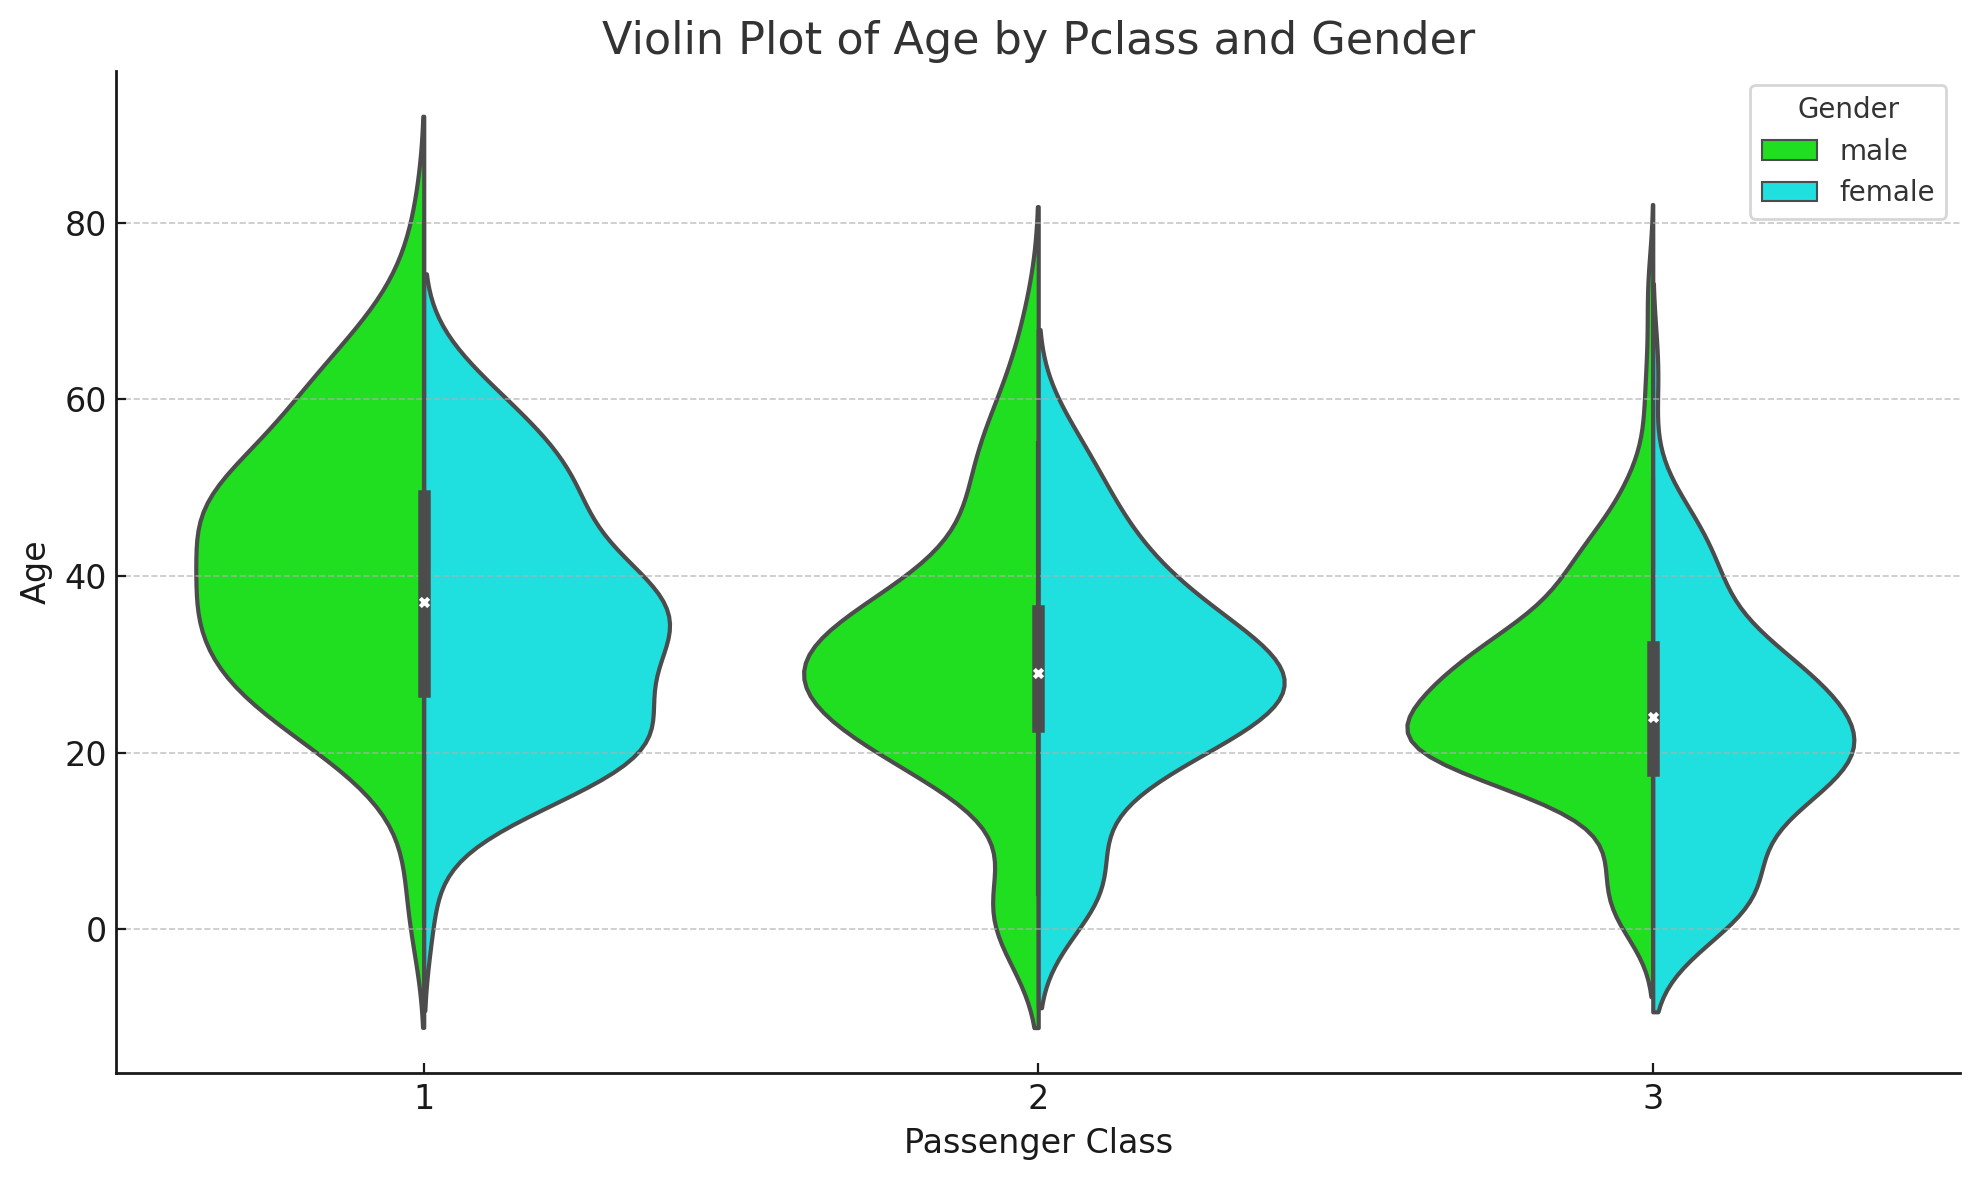

In [27]:
from IPython.display import Image, display
from pathlib import Path

file_id = img.image_file.file_id
file_name = f"./{file_id}_image_file.png"
file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))

## Example

In [28]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate the age distribution. Use lightblue color"

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_N7srSYQ0Wlp2SV6w418YnyyT
Created message, message ID: msg_1AyIPwczbXDlAhxRX2AIZV5o


In [29]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

run.usage

Created run, run ID: run_aDd5c74p00qPT90BQFY6WyE8


{'prompt_tokens': 2695, 'completion_tokens': 302, 'total_tokens': 2997, 'prompt_token_details': {'cached_tokens': 0}}

In [30]:
    IMAGES_DIR = "images"

    images_list = []

    # [START get_messages_and_save_files]
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x127c786b0>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/1_Azure Agent Service/NOTEBOOKS/assistant-JHLEiHbjZqoSKASW6Q7UnY_image_file.png
MessageRole.AGENT: The file appears to be the Titanic dataset, and the `Age` column contains the age data. Now, I'll generate the age distribution using a light blue color.
MessageRole.AGENT: Let me first inspect the file to understand its structure and find the column containing age data. Then, I will generate the age distribution as requested using a light blue color scheme.
MessageRole.USER: Generate the age distribution. Use lightblue color


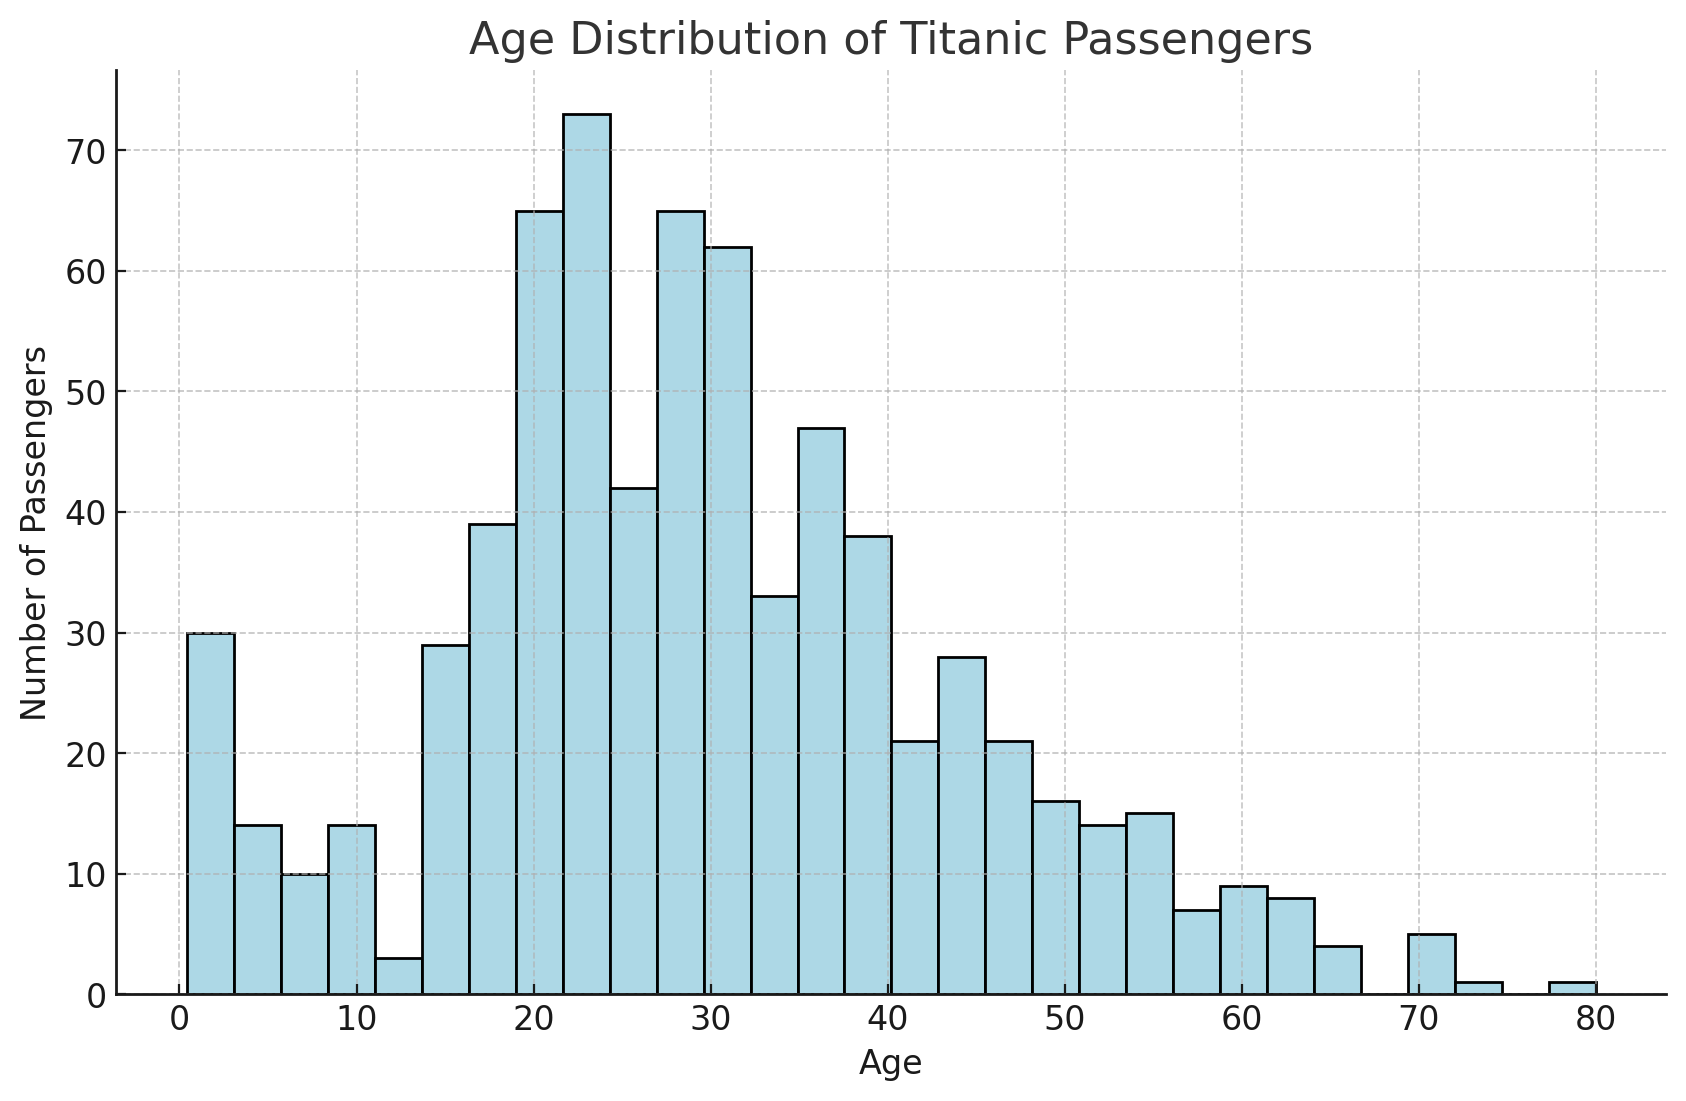

In [31]:
from IPython.display import Image, display
from pathlib import Path

file_id = img.image_file.file_id
file_name = f"./{file_id}_image_file.png"
file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))

## All images

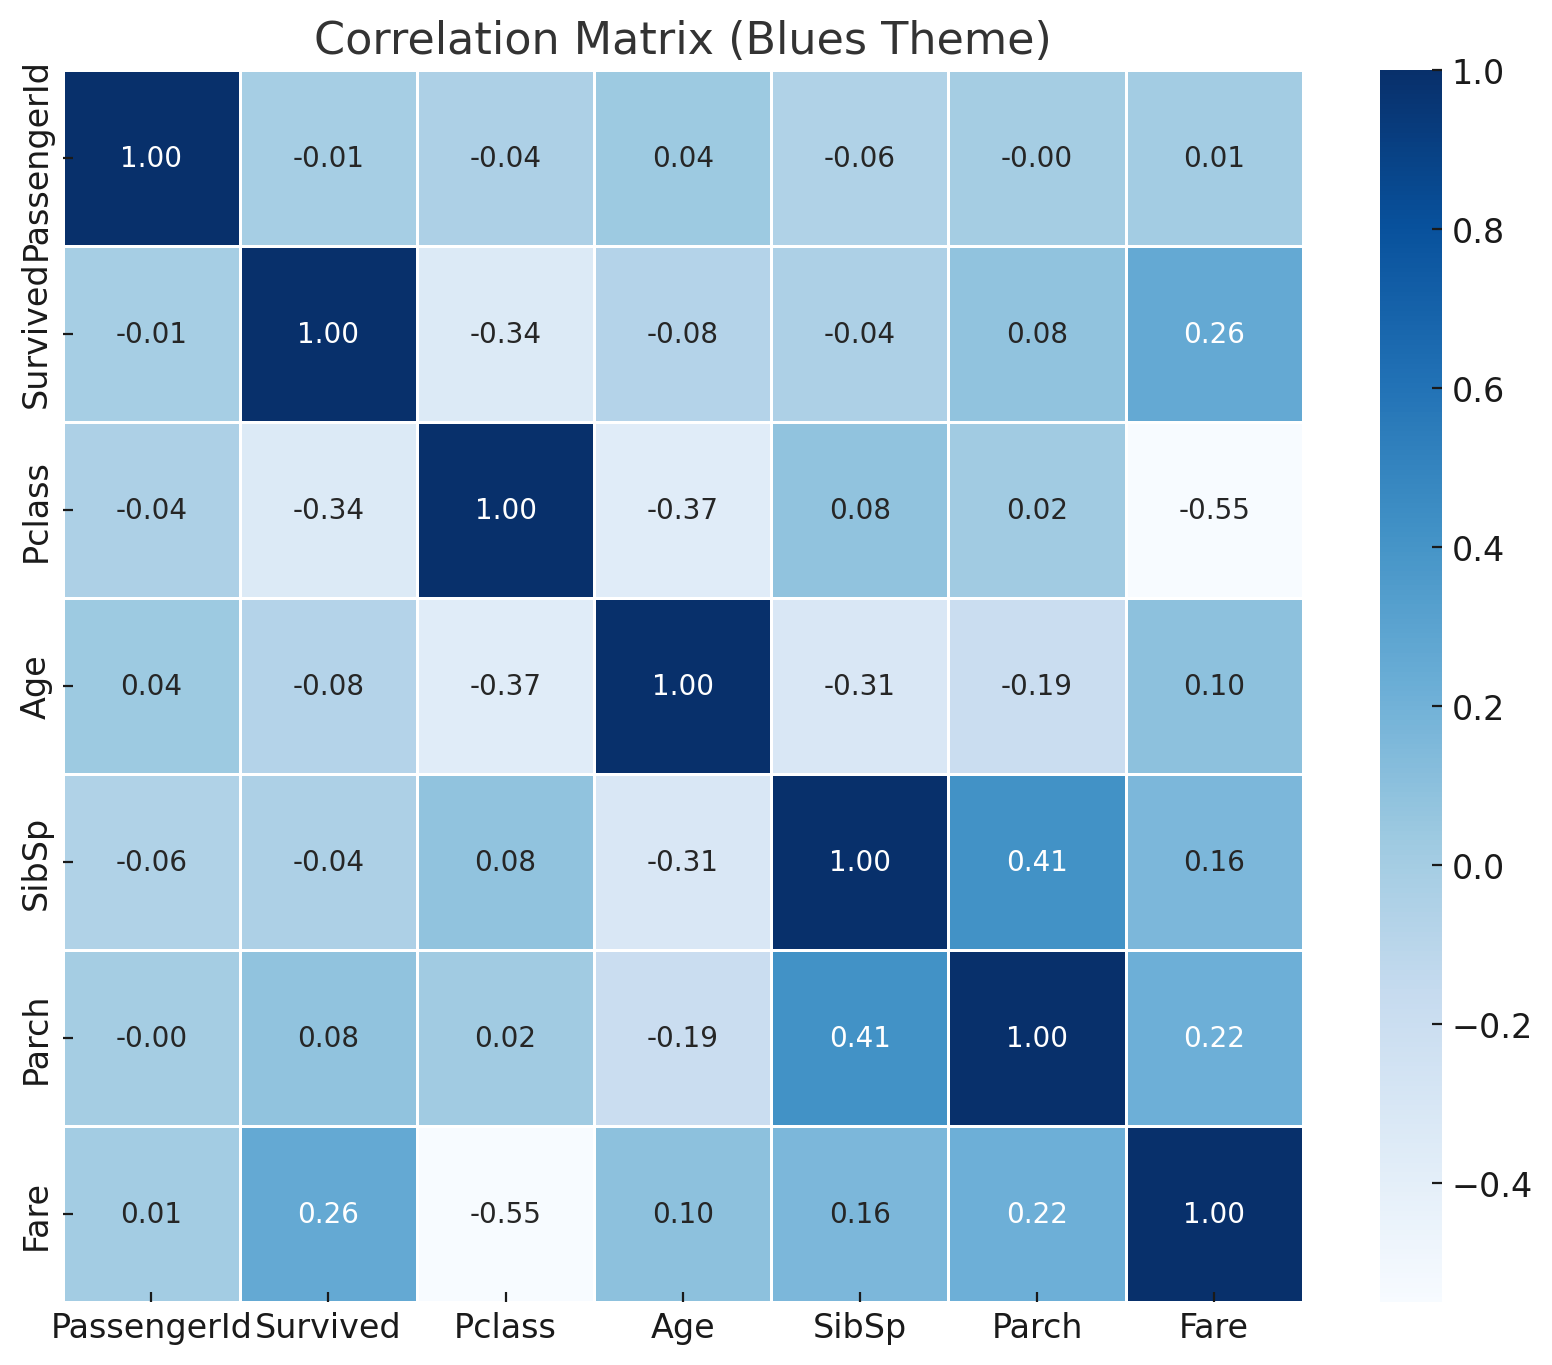

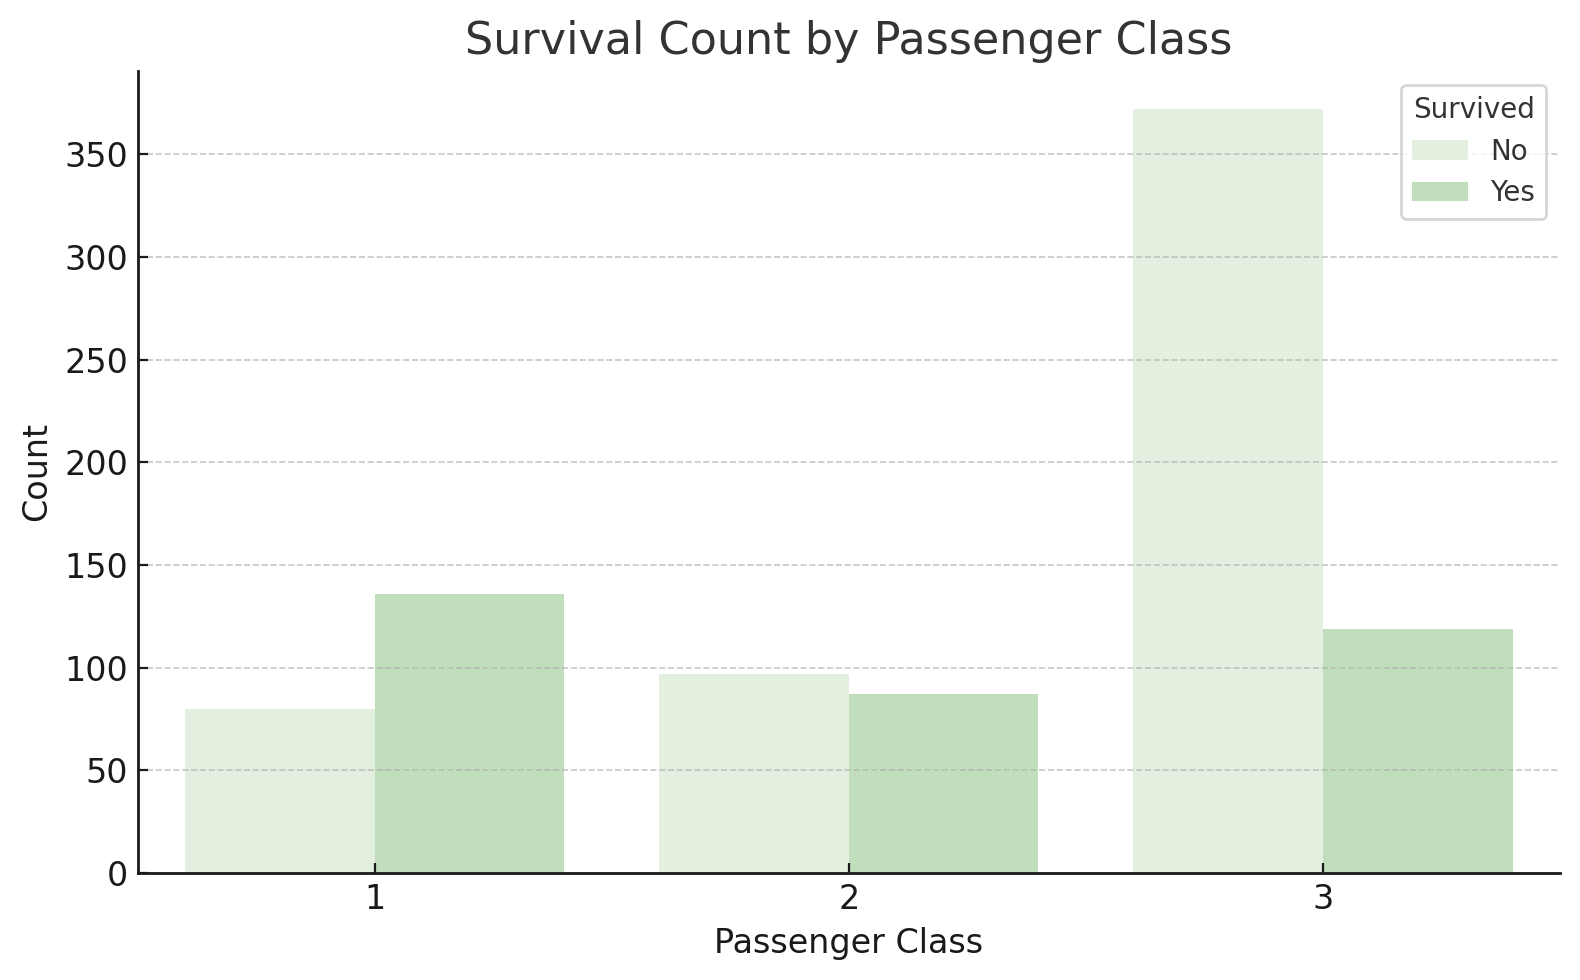

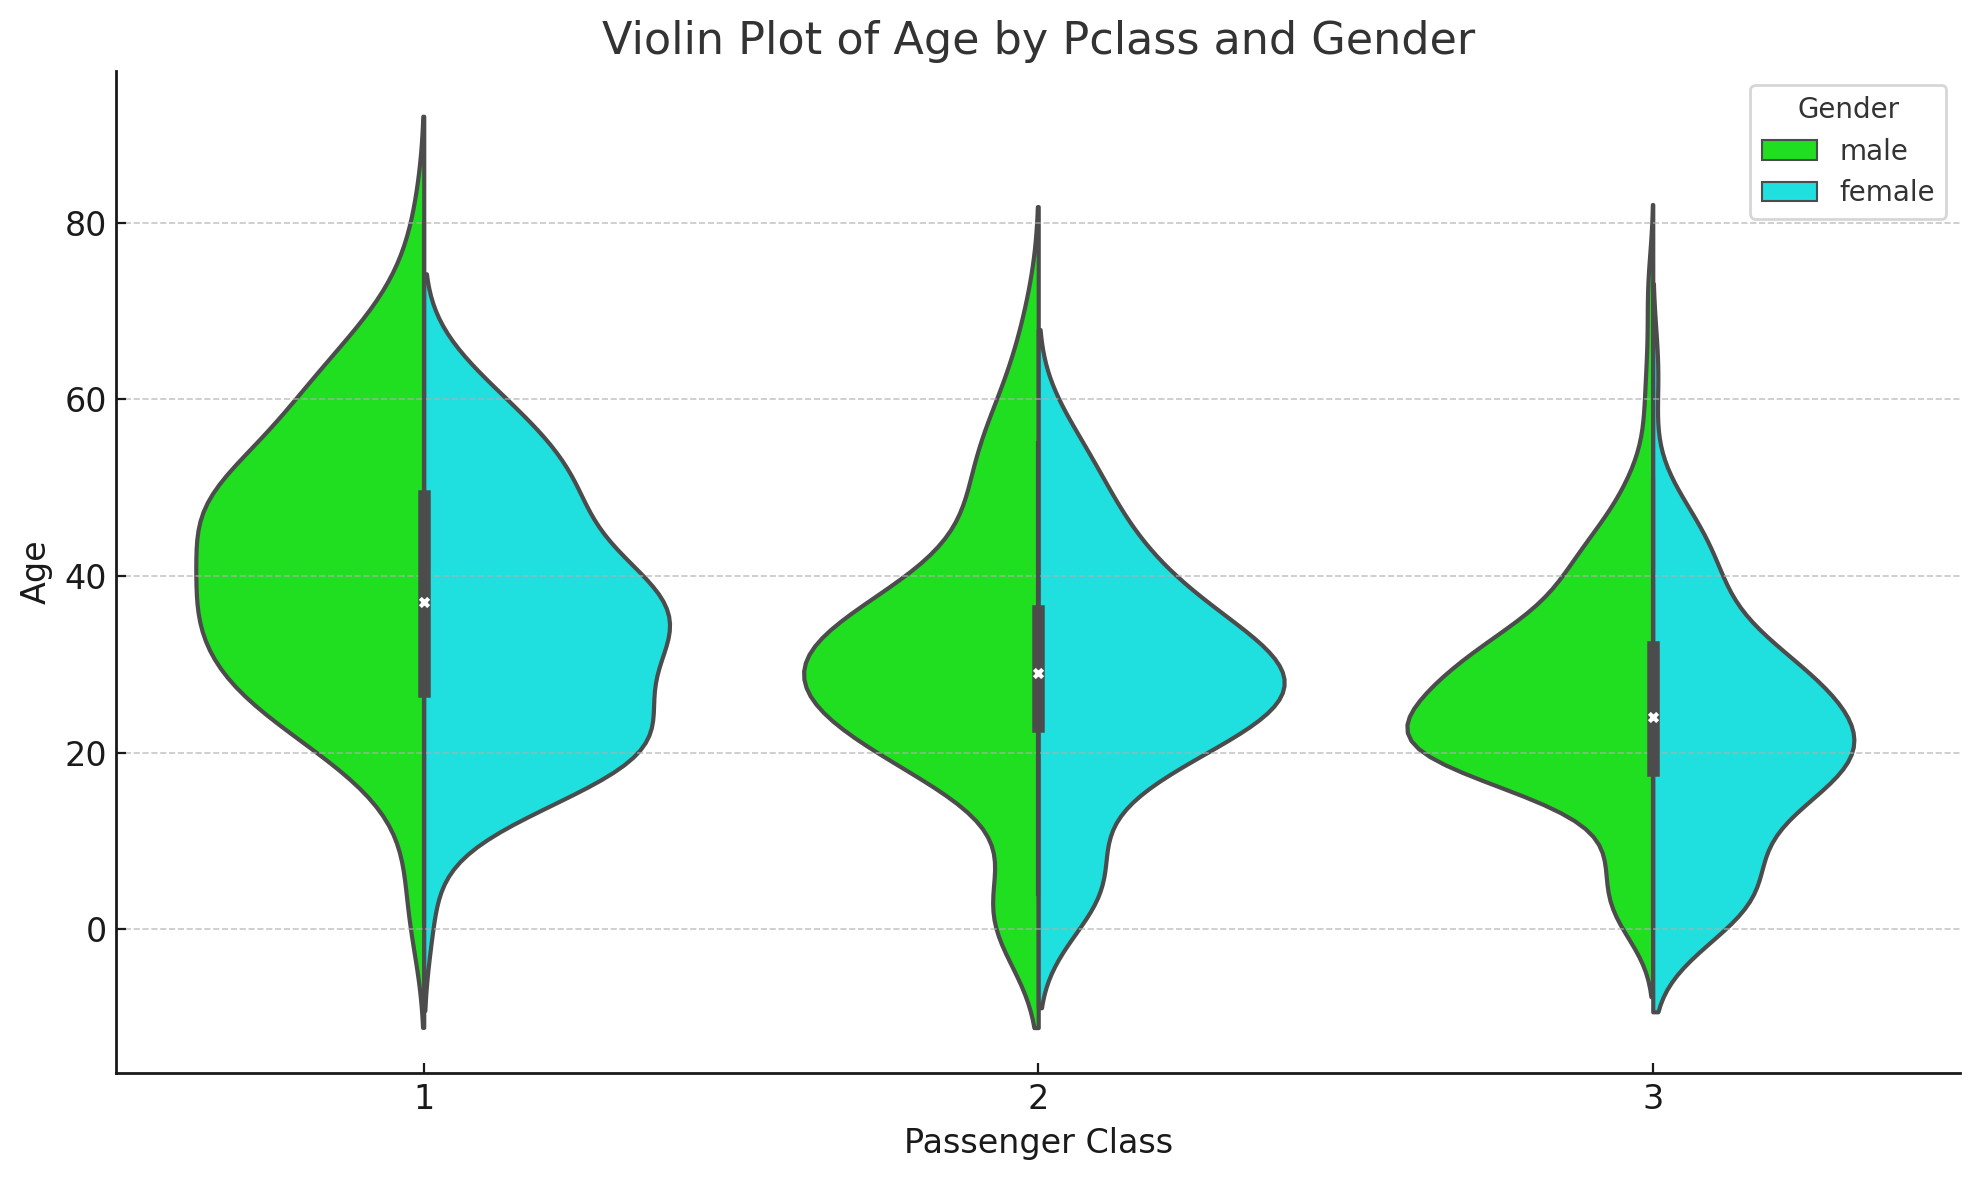

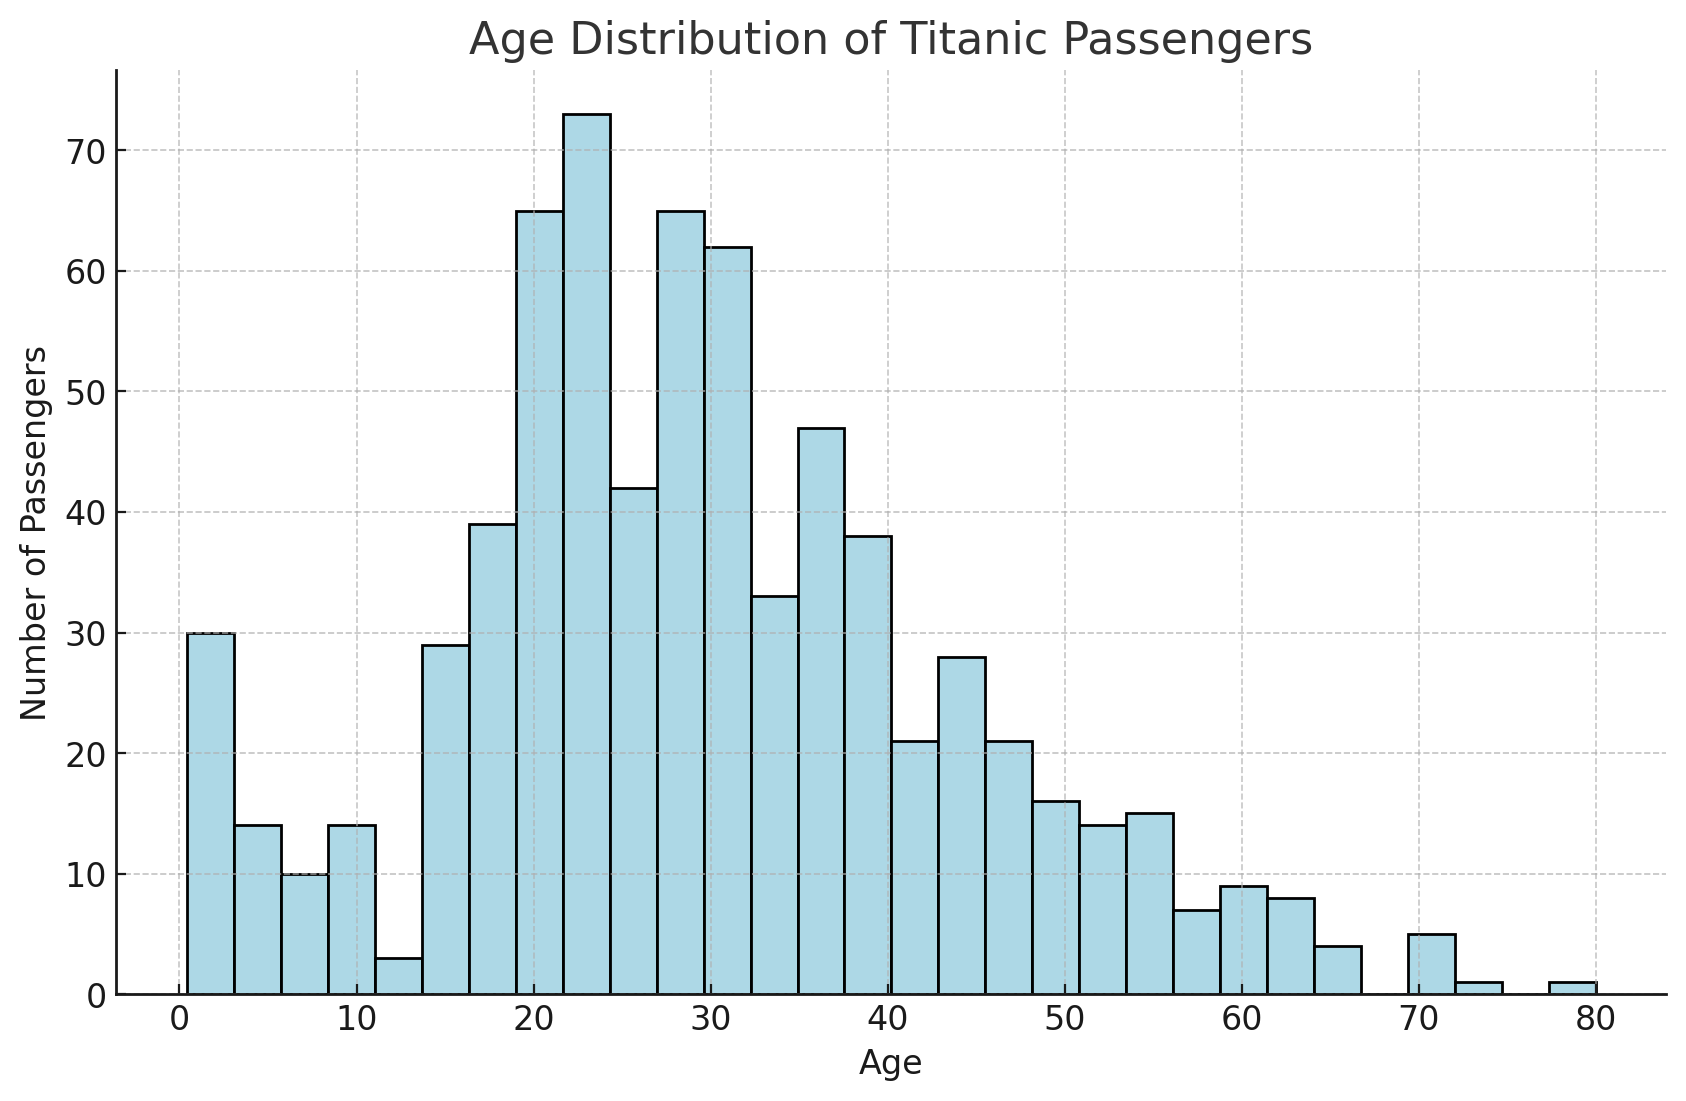

In [32]:
from IPython.display import display, Image
from pathlib import Path

# Define the directory to search for images (current working directory)
image_dir = Path.cwd()

# Find all files matching the pattern 'assistant-*.png'
image_files = sorted(
    [f for f in image_dir.glob('assistant-*.png')],
    key=lambda x: x.stat().st_mtime
)

if image_files:
    for img_path in image_files:
        display(Image(filename=str(img_path)))
else:
    print('No assistant-*.png files found in the current directory.')

## Cleaning

In [29]:
project_client.delete_agent(agent.id)
print(f"Deleted agent, agent ID: {agent.id}")

Deleted agent, agent ID: asst_Sfo7xnvStX63cPufGl847SKt
